<a href="https://colab.research.google.com/github/Vamsi-Malineni/CS5691_Machine_Learning_Models/blob/main/Regression/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import math 
from numpy import genfromtxt
import matplotlib.pyplot as plt

In [3]:
dataset = genfromtxt(r'/content/drive/MyDrive/Assignment1 datasets/2_music.txt', delimiter=',')

# shape of data = (1058,69)
X = dataset[:,0:68]     #it has 68 columns 
t = dataset[:,68:70]    #It has 2 columns

#-----------Data pre processing using feature scaling (Standardization)-------------
mean_X = np.reshape((np.sum(X,axis = 0)/len(X)),(68,1)) 
mean_t = np.reshape((np.sum(t,axis = 0)/len(t)),(2,1))
var_X = np.zeros((len(X),68), dtype = float)
var_t = np.zeros((len(t),2), dtype = float)
for i in range(len(X)):
    var_X[i,:] = np.power((X[i,:] - mean_X.T),2)
    var_t[i,:] = np.power((t[i,:] - mean_t.T),2)

#Calculating Standard deviation   
std_dev_X = np.sqrt(np.reshape((np.sum(var_X,axis=0)/(len(X))),(68,1)))
std_dev_t = np.sqrt(np.reshape((np.sum(var_t,axis = 0)/(len(t))),(2,1)))

X_new = np.zeros((len(X),68),dtype = float)
t_new = np.zeros((len(X),2),dtype = float)
#Final feature scaling (i.e X = (x - mean) / std_dev) )
for i in range(len(X)):
    for j in range(68):
        X_new[i,j] = (X[i,j] - (mean_X.T)[:,j])/std_dev_X[j,:]
for i in range(len(X)):
    for j in range(2):
        t_new[i,j] = (X[i,j] - (mean_t.T)[:,j])/std_dev_t[j,:]


In [4]:
d = 68                                                      #No. of features
L = 2                                                       #No.of outputs
k = 10                                                      #number of clusters
sigma = 250
N_total = len(X)                                            #total number of dataset
N_train = int(0.7*N_total)                                  #training data
N_test = int(0.2*N_total)                                   #testing data
N_validate = int(0.1*N_total)                               #validation data
C = N_total//N_train                                        #Number of times cross validation will run
t_train = t_new[0:N_train,:]                                #training data system output
t_test = t_new[N_train:(N_train+N_test),:]                  #testing data system output
t_validate = t_new[(N_train+N_test):(N_validate+N_train+N_test),:]          #validating data system output
X_train = X_new[0:N_train,:]                                 #input data for training
X_test = X_new[N_train:(N_train + N_test) , :]               #input data for testing
X_validate = X_new[(N_train + N_test):(N_validate+N_train+N_test) , : ]         #input data for validating
lamda = np.exp(-18)                                          #Regularizing paramater value


In [5]:
# Function for calculating K-Means Clustering 
def k_means_clustering(X,k,N_total,itteration,d):
    a = np.arange(N_total)      #getting length of X
    mean_index_initial = np.random.choice(a,k)     #getting random index from X
    mean_value_initial = X[mean_index_initial,:]
    z = np.zeros((N_total,k),dtype = int)
    N_index = np.zeros((k,1), dtype = int)
    mean_value = np.zeros((2,k,d),dtype = float)
    
    for p in range(itteration):
        q = 1
        if(p==0):
            mean_value[q-1] = mean_value_initial
        else:
            mean_value[q] = update_mean(X,mean_value[q-1],z,k,N_total,N_index,d)
            compare = mean_value[q] == mean_value[q-1]
            if(compare.all()):
                mean_value_final = mean_value[q]
                print("Converged Means")
                break
            mean_value[q-1] = mean_value[q]
            mean_value[q] = 0
    return mean_value_final

def update_mean(X,mean_previous,z,k,N_total,N_index,d):
    a = np.zeros((k,1),dtype=float)
    z = np.zeros((N_total,k),dtype = float)
    mean_value = np.zeros((k,d), dtype= float)
    for l in range(N_total):
        a = X[l] - mean_previous
        b = np.sum(np.square(a),axis = 1)
        c = np.reshape(b,(k,1))
        index = np.argmin(c)
        z[l,index] = 1                            #Calculating Zni parameter

    for i in range(k):
        d = np.reshape(z[:,i],(N_total,1))
        N_index[i] = np.sum(d)
        mean_value[i,:] = (np.sum((d*X),axis = 0))/N_index[i]     #updating mean value     
    return mean_value

converged_mean = k_means_clustering(X,k,N_total,100000000,d)   #Getting final mean after K-means clustering

Converged Means


In [6]:

#Function to generate Gaussian basis function
def generate_phi(converged_mean,X_train,N_train,k,sigma):
    phi = np.zeros((N_train ,k), dtype = float)
    for i in range(N_train):
        a = X_train[i,:] - converged_mean
        b = np.sum(np.square(a),axis = 1)
        c = np.reshape(b,(k,1))
        for j in range(k):
            phi[i,j] = math.exp(-0.5*c[j]/(np.square(sigma)))    #Gaussian function approach for basis function
    return phi

Train Error (Without Regularization)
0.01880480301985993
Test Error (Without Regularization)
0.019497607956751248
Validate Error (Without Regularization)
0.01557063577321988


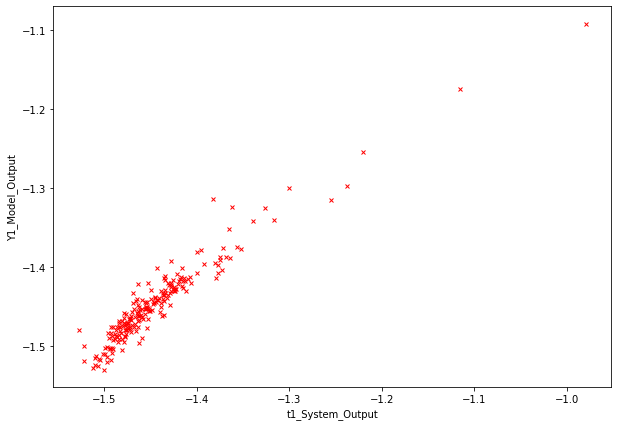

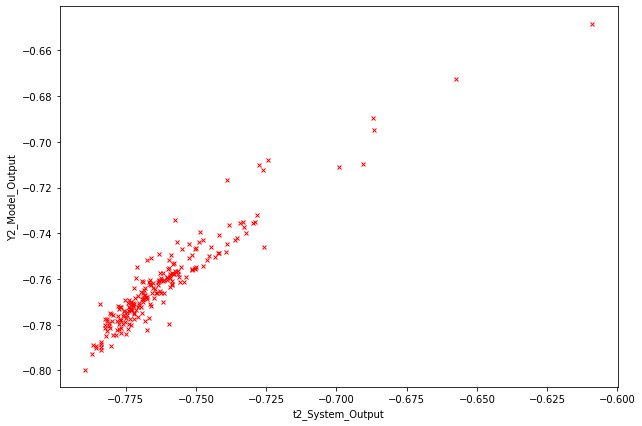

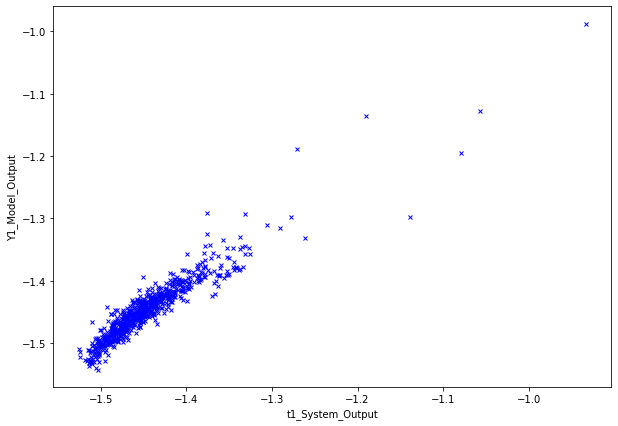

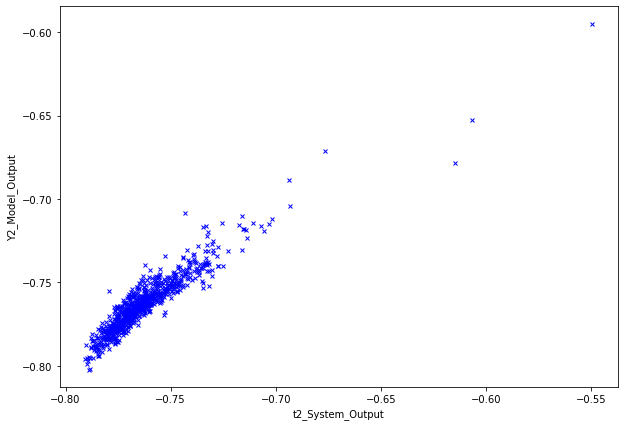

In [7]:

##############################################################################
######################------without regularization------#########################
##############################################################################


# Using Cross Validation to optimize 'w' parameter 
def optimize_para(converged_mean,X,t,N_train,k,C,sigma,L):
    w_star_intermediate = np.zeros((C,k,L),dtype =float)
    error = np.zeros((C,1),dtype = float)
    for i in range(C):
        phi_train = generate_phi(converged_mean,X[(N_train*i) : (N_train*(i+1)),:],N_train,k,sigma)
            
        #optimize parameter after training the data
        A2 = np.dot(np.transpose(phi_train),phi_train)
        B2 = np.linalg.inv(A2)
        pseudo_inv_phi = np.dot(B2,np.transpose(phi_train))
        w_star_intermediate[i,:,:] = np.dot(pseudo_inv_phi,t[(N_train*i):(N_train*(i+1)),:])   #optimal value of parameter
        #calculating error
        error[i] = 0.5*np.sum(np.power((np.dot(phi_train,w_star_intermediate[i,:,:]) - t[(N_train*i):(N_train*(i+1))] ),2))
        
    #Choosing index for minimum of all the error values calculated using cross validation
    a = np.argmin(error)                
    w_star_optimum = w_star_intermediate[a,:,:]        #Optimum value of 'w' parameter
    return w_star_optimum,phi_train   
#---------------------------------------------------------------------------------------


#function for the output of testing model
def output_model_test(X,t,converged_mean,X_test,N_train,N_test,k,sigma,L):
    #Generating Gaussian Function phi
    phi_test = generate_phi(converged_mean,X_test,N_test,k,sigma) 
        
    w_star_optimum,phi_train = optimize_para(converged_mean,X,t ,N_train,k,C,sigma,L)
    #model output for testing data
    Y_test = np.dot(phi_test,w_star_optimum)
    return Y_test,phi_train,w_star_optimum
#-----------------------------------------------------------------------------------------------------#


#Testing and Training Data Output
F1,phi_train,w_star_optimum= output_model_test(X_new,t_new,converged_mean,X_test,N_train,N_test,k,sigma,L)
Y_test1 = np.reshape(F1[:,0],(N_test,1))           #Model Output for testing 1
Y_test2 = np.reshape(F1[:,1],(N_test,1))           #Model Output for testing 2

# Calculating Training Data Error
Y_train = np.dot(phi_train,w_star_optimum) 
error_train=0.5*(np.sum(np.power((Y_train-t_train),2)))
erms_train=math.pow(((2*error_train)/N_train),0.5)
print("Train Error (Without Regularization)")
print(erms_train)

# Calculating Testing Data Error
error=0.5*(np.sum(np.power((F1-t_test),2)))
erms_test=math.pow(((2*error)/N_test),0.5)
print("Test Error (Without Regularization)")
print(erms_test)

#-----------------------------------------------------------------------------------------------------#

#Validating Data Output
Y_validate,phi_train,w_star_optimum = output_model_test(X_new,t_new,converged_mean,X_validate,N_train,N_validate,k,sigma,L)
error_validate=0.5*np.sum(np.power((Y_validate-t_validate),2))
erms_validate=np.power(((2*error_validate)/N_validate),0.5)
print("Validate Error (Without Regularization)")
print(erms_validate)
#-----------------------------------------------------------------------------------------------------#


#--------Scatter Plots Without regularization--------------#
#For testing data output 1
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
ax.plot(t_test[:,0],Y_test1,"rx",MarkerSize=4)
plt.ylabel("Y1_Model_Output")
plt.xlabel("t1_System_Output")
plt.show(1)

#For testing data output 2
fig2 = plt.figure(figsize = (10, 7))
ax1 = fig2.add_subplot(111)
ax1.plot(t_test[:,1],Y_test2,"rx",MarkerSize=4)
plt.ylabel("Y2_Model_Output")
plt.xlabel("t2_System_Output")
plt.show(2)

fig3 = plt.figure(figsize = (10, 7))
ax3 = fig3.add_subplot(111)
ax3.plot(t_train[:,0],Y_train[:,0],"bx",MarkerSize=4)
plt.ylabel("Y1_Model_Output")
plt.xlabel("t1_System_Output")
plt.show(3)

fig4 = plt.figure(figsize = (10, 7))
ax4 = fig4.add_subplot(111)
ax4.plot(t_train[:,1],Y_train[:,1],"bx",MarkerSize=4)
plt.ylabel("Y2_Model_Output")
plt.xlabel("t2_System_Output")
plt.show(4)


Training Error (With Quadratic Regularizer)
0.01881300354890459
Test Error (With Quadratic Regularizer)
0.01952741538079177
Validate Error (With Quadratic Regularizer)
0.015480865469920875


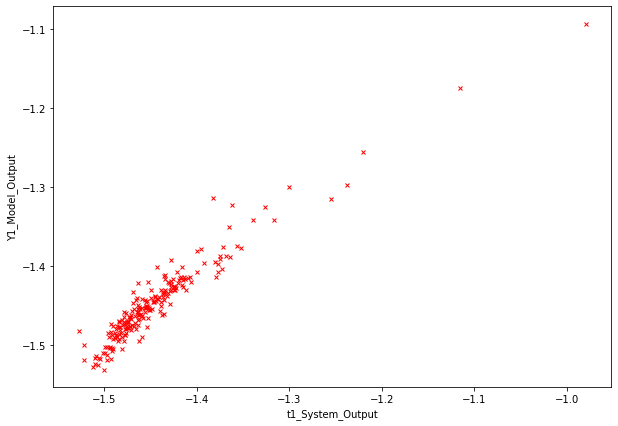

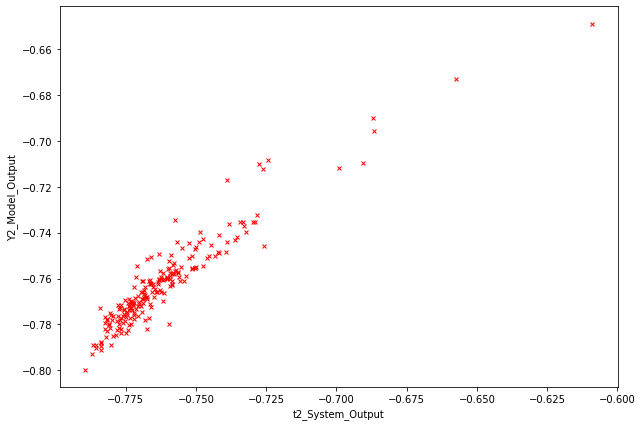

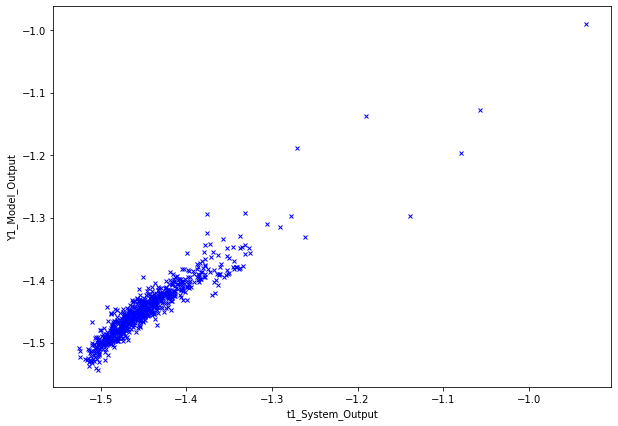

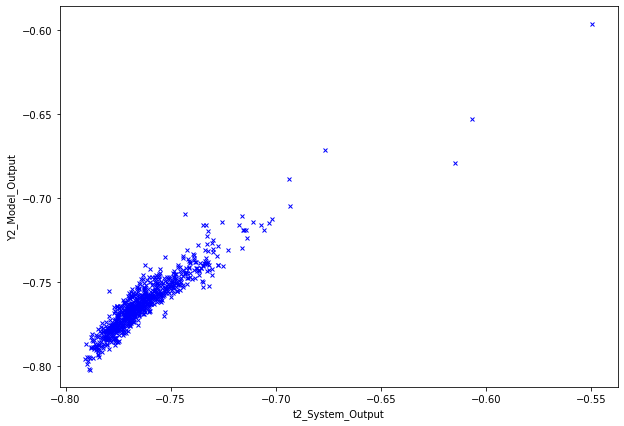

In [8]:
##############################################################################
######################------With Quadratic Regularization------#########################
##############################################################################

# Using Cross Validation to optimize 'w' parameter 
def optimize_para_qr(converged_mean,X,t,N_train,k,C,sigma,L,lamda):
    w_star_intermediate = np.zeros((C,k,L),dtype =float)
    error = np.zeros((C,1),dtype = float)
    for i in range(C):
        phi_train = generate_phi(converged_mean,X[(N_train*i) : (N_train*(i+1)),:],N_train,k,sigma)
            
        #optimize parameter after training the data
        A2 = np.dot(np.transpose(phi_train),phi_train)
        B2 = np.linalg.inv(A2 + lamda*np.identity(k,dtype =float))
        pseudo_inv_phi = np.dot(B2,np.transpose(phi_train))
        w_star_intermediate[i,:,:] = np.dot(pseudo_inv_phi,t[(N_train*i):(N_train*(i+1)),:])   #optimal value of parameter
        #calculating error
        error[i] = 0.5*np.sum(np.power((np.dot(phi_train,w_star_intermediate[i,:,:]) - t[(N_train*i):(N_train*(i+1))] ),2))
        
    a = np.argmin(error)
    w_star_optimum = w_star_intermediate[a,:,:]
    return w_star_optimum,phi_train   

#function for the output of testing model
def output_model_test_qr(X,t,converged_mean,X_test,N_train,N_test,k,sigma,L,lamda):
    #Generating Gaussian Function
    phi_test = generate_phi(converged_mean,X_test,N_test,k,sigma)
        
    w_star_optimum,phi_train = optimize_para_qr(converged_mean,X,t ,N_train,k,C,sigma,L,lamda)
    #model output for testing data
    Y_test = np.dot(phi_test,w_star_optimum)
    return Y_test,phi_train,w_star_optimum
#-----------------------------------------------------------------------------------------------------#

#Testing and Training Data Output
F1_qr,phi_train_qr,w_star_optimum_qr= output_model_test_qr(X_new,t_new,converged_mean,X_test,N_train,N_test,k,sigma,L,lamda)
#F2 = output_model_test(X_new,t_new[:,1],converged_mean,X_test,N_train,N_test,k,sigma)
Y_test1_qr = np.reshape(F1_qr[:,0],(N_test,1))           #Model Output 1
Y_test2_qr = np.reshape(F1_qr[:,1],(N_test,1))           #Model Output 2

# Calculating Training Data Error
Y_train_qr = np.dot(phi_train_qr,w_star_optimum_qr) 
error_train_qr = 0.5*(np.sum(np.power((Y_train_qr-t_train),2)))
erms_train_qr = math.pow(((2*error_train_qr)/N_train),0.5)
print("Training Error (With Quadratic Regularizer)")
print(erms_train_qr)

# Calculating Test Data Error
error_test_qr = 0.5*(np.sum(np.power((F1_qr-t_test),2)))
erms_test_qr = math.pow(((2*error_test_qr)/N_test),0.5)
print("Test Error (With Quadratic Regularizer)")
print(erms_test_qr)
#-----------------------------------------------------------------------------------------------------#

#Validating Data Output 
Y_validate_qr,phi_train_qr,w_star_optimum_qr = output_model_test_qr(X_new,t_new,converged_mean,X_validate,N_train,N_validate,k,sigma,L,lamda)
error_validate_qr = 0.5*np.sum(np.power((Y_validate_qr-t_validate),2))
erms_validate_qr = np.power(((2*error_validate_qr)/N_validate),0.5)
print("Validate Error (With Quadratic Regularizer)")
print(erms_validate_qr)
#-----------------------------------------------------------------------------------------------------#

#--------Scatter Plots With Quadratic Regularization--------------#
#For testing data output 1
fig5 = plt.figure(figsize = (10, 7))
ax5 = fig5.add_subplot(111)
ax5.plot(t_test[:,0],Y_test1_qr,"rx",MarkerSize=4)
plt.ylabel("Y1_Model_Output")
plt.xlabel("t1_System_Output")
plt.show(5)
#For testing data output 2
fig6 = plt.figure(figsize = (10, 7))
ax6 = fig6.add_subplot(111)
ax6.plot(t_test[:,1],Y_test2_qr,"rx",MarkerSize=4)
plt.ylabel("Y2_Model_Output")
plt.xlabel("t2_System_Output")
plt.show(6)
# For training data output 1
fig7 = plt.figure(figsize = (10, 7))
ax7 = fig7.add_subplot(111)
ax7.plot(t_train[:,0],Y_train_qr[:,0],"bx",MarkerSize=4)
plt.ylabel("Y1_Model_Output")
plt.xlabel("t1_System_Output")
plt.show(7)
# For training data output 2
fig8 = plt.figure(figsize = (10, 7))
ax8 = fig8.add_subplot(111)
ax8.plot(t_train[:,1],Y_train_qr[:,1],"bx",MarkerSize=4)
plt.ylabel("Y2_Model_Output")
plt.xlabel("t2_System_Output")
plt.show(8)


Training Error (With Tikonov Regularizer)
0.018804802891343238
Test Error (With Tikonov Regularizer)
0.019497412874867642
Validate Error (With Tikonov Regularizer)
0.015570366066822409


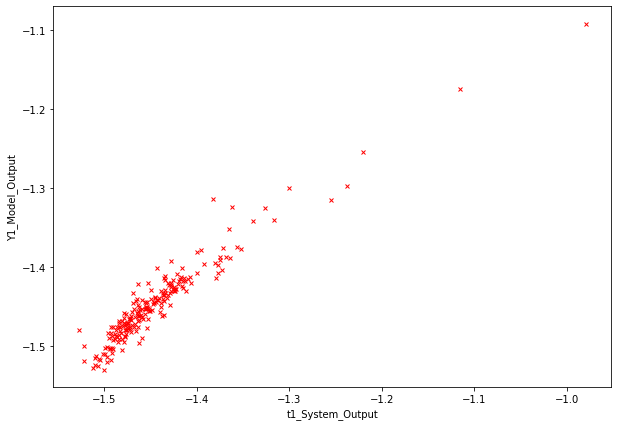

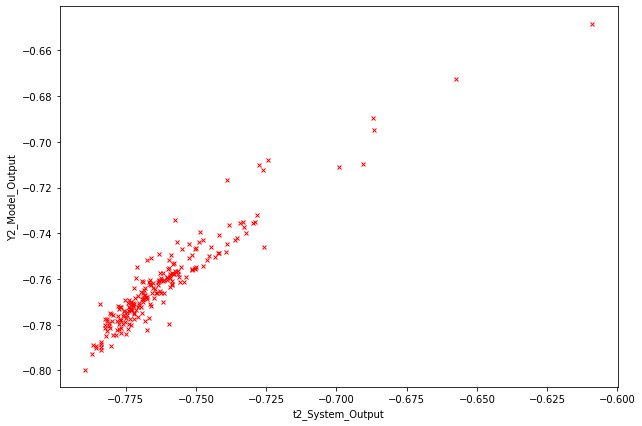

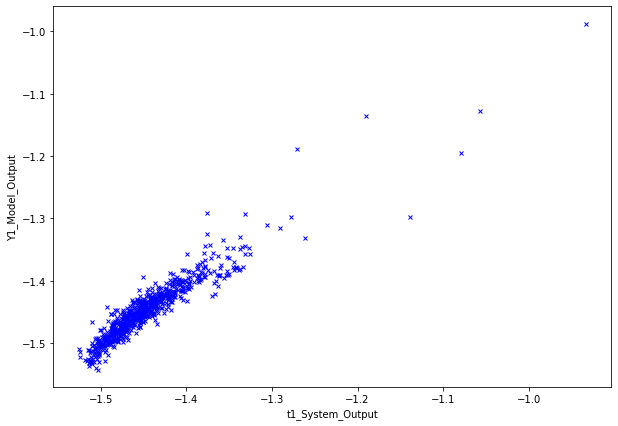

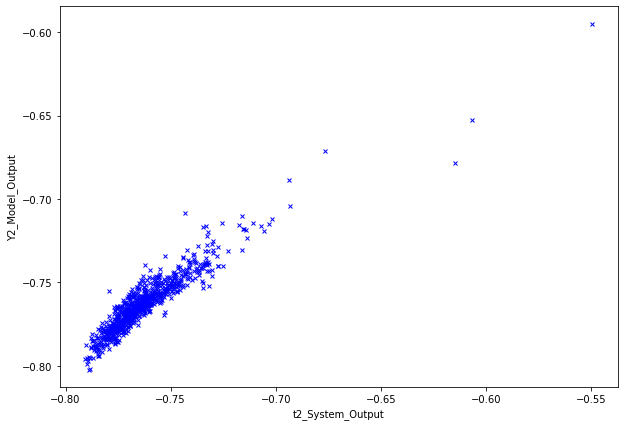

In [9]:
##############################################################################
######################------With Tikonov Regularization------#########################
##############################################################################

# Function for generating phi_tilda for Tikonov regularization 
def phi_tilda(converged_mean,k,sigma):
    phi_tilda = np.zeros((k ,k), dtype = float)
    for i in range(k):
        for j in range(k):
            a = converged_mean[i,:] - converged_mean[j,:]
            b = np.reshape(a,(68,1))
            c = np.sum(np.square(b),axis = 0)
            phi_tilda[i,j] = math.exp(-0.5*c/(np.square(sigma)))    #Gaussian function approach for basis function        
    return phi_tilda

# Using Cross Validation to optimize 'w' parameter 
def optimize_para_tr(converged_mean,X,t,N_train,k,C,sigma,L,lamda):
    w_star_intermediate = np.zeros((C,k,L),dtype =float)
    error = np.zeros((C,1),dtype = float)
    for i in range(C):
        phi_train = generate_phi(converged_mean,X[(N_train*i) : (N_train*(i+1)),:],N_train,k,sigma)
            
        #optimize parameter after training the data
        A2 = np.dot(np.transpose(phi_train),phi_train)
        B2 = np.linalg.inv(A2 + lamda*(phi_tilda(converged_mean,k,sigma)))
        pseudo_inv_phi = np.dot(B2,np.transpose(phi_train))
        w_star_intermediate[i,:,:] = np.dot(pseudo_inv_phi,t[(N_train*i):(N_train*(i+1)),:])   #optimal value of parameter
        #calculating error
        error[i] = 0.5*np.sum(np.power((np.dot(phi_train,w_star_intermediate[i,:,:]) - t[(N_train*i):(N_train*(i+1))] ),2))
    a = np.argmin(error)
    w_star_optimum = w_star_intermediate[a,:,:]
    #Y_train = np.dot(phi_train,w_star_optimum)                               #model output for training data
    return w_star_optimum,phi_train   

#function for the output of testing model
def output_model_test_tr(X,t,converged_mean,X_test,N_train,N_test,k,sigma,L,lamda):
    #Generating Gaussian Function
    phi_test = generate_phi(converged_mean,X_test,N_test,k,sigma)
        
    w_star_optimum,phi_train = optimize_para_tr(converged_mean,X,t ,N_train,k,C,sigma,L,lamda)
    #model output for testing data
    Y_test = np.dot(phi_test,w_star_optimum)
    return Y_test,phi_train,w_star_optimum
#-----------------------------------------------------------------------------------------------------#

#Testing and Training Data Output
F1_tr,phi_train_tr,w_star_optimum_tr= output_model_test_tr(X_new,t_new,converged_mean,X_test,N_train,N_test,k,sigma,L,lamda)
Y_test1_tr = np.reshape(F1_tr[:,0],(N_test,1))           #Model Output for Testing 1
Y_test2_tr = np.reshape(F1_tr[:,1],(N_test,1))           #Model Output for Testing 2

# Calculating Training Data Error
Y_train_tr = np.dot(phi_train_tr,w_star_optimum_tr) 
error_train_tr = 0.5*(np.sum(np.power((Y_train_tr-t_train),2)))
erms_train_tr = math.pow(((2*error_train_tr)/N_train),0.5)
print("Training Error (With Tikonov Regularizer)")
print(erms_train_tr)

# Calculating Test Data Error
error_test_tr = 0.5*(np.sum(np.power((F1_tr-t_test),2)))
erms_test_tr = math.pow(((2*error_test_tr)/N_test),0.5)
print("Test Error (With Tikonov Regularizer)")
print(erms_test_tr)
#-----------------------------------------------------------------------------------------------------#

#Validating Data Output 
Y_validate_tr,phi_train_tr,w_star_optimum_tr = output_model_test_tr(X_new,t_new,converged_mean,X_validate,N_train,N_validate,k,sigma,L,lamda)
error_validate_tr = 0.5*np.sum(np.power((Y_validate_tr-t_validate),2))
erms_validate_tr = np.power(((2*error_validate_tr)/N_validate),0.5)
print("Validate Error (With Tikonov Regularizer)")
print(erms_validate_tr)
#-----------------------------------------------------------------------------------------------------#

#--------Scatter Plots With Tikonov Regularization--------------#
# For testing data output 1
fig9 = plt.figure(figsize = (10, 7))
ax9 = fig9.add_subplot(111)
ax9.plot(t_test[:,0],Y_test1_tr,"rx",MarkerSize=4)
plt.ylabel("Y1_Model_Output")
plt.xlabel("t1_System_Output")
plt.show(9)
# For testing data output 2
fig10 = plt.figure(figsize = (10, 7))
ax10 = fig10.add_subplot(111)
ax10.plot(t_test[:,1],Y_test2_tr,"rx",MarkerSize=4)
plt.ylabel("Y2_Model_Output")
plt.xlabel("t2_System_Output")
plt.show(10)
# For training data output 1
fig11 = plt.figure(figsize = (10, 7))
ax11 = fig11.add_subplot(111)
ax11.plot(t_train[:,0],Y_train_tr[:,0],"bx",MarkerSize=4)
plt.ylabel("Y1_Model_Output")
plt.xlabel("t1_System_Output")
plt.show(11)
# For training data output 2
fig12 = plt.figure(figsize = (10, 7))
ax12 = fig12.add_subplot(111)
ax12.plot(t_train[:,1],Y_train_tr[:,1],"bx",MarkerSize=4)
plt.ylabel("Y2_Model_Output")
plt.xlabel("t2_System_Output")
plt.show(12)



